"YOLO" (You Only Live Once) in the context of object detection refers to a series of deep learning models for real-time object detection. YOLO models are known for their speed and efficiency, making them popular in applications that require real-time detection, like video analysis or autonomous vehicles. Here's a brief overview of the YOLO object detection method:

1. **Single Neural Network Architecture**: Unlike other object detection methods that might use separate networks or stages for different parts of the detection process (like region proposal and classification), YOLO applies a single neural network to the entire image. This network divides the image into a grid and predicts bounding boxes and probabilities for each grid cell.

2. **Speed and Efficiency**: YOLO models are designed for speed, which allows them to perform object detection in real-time. This is achieved by the model's ability to look at the entire image during training and testing, which means it can implicitly encode contextual information about classes as well as their appearance.

3. **Versions and Improvements**: There have been several iterations of YOLO, each improving upon the last. These include YOLOv2 (or YOLO9000), YOLOv3, and the latest versions like YOLOv4 and YOLOv5. Each version introduces improvements in accuracy, speed, and the ability to detect small objects.

4. **Applications**: YOLO's real-time processing capability makes it suitable for applications like surveillance, traffic monitoring, and autonomous driving where detecting objects swiftly and accurately is crucial.

5. **Limitations**: While YOLO is fast, it can sometimes lag behind other methods in terms of detection accuracy, especially with small objects or objects that appear in groups.

6. **Training and Implementation**: YOLO models are trained on large datasets like COCO (Common Objects in Context) and can be implemented using various deep learning frameworks such as TensorFlow or PyTorch.

YOLO's approach to object detection, treating it as a regression problem to spatially separated bounding boxes and associated class probabilities, was revolutionary and has had a significant impact on the field of computer vision.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import torch.optim as optim
from torchvision.models import resnet18

from tqdm import tqdm

seed = 123
torch.manual_seed(seed)


from PIL import Image

import numpy as np
import pandas as pd

import os
from collections import Counter

In [2]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [3]:
class CNNBLock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.layer_norm = nn.LayerNorm(self.in_channels)
        self.conv = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, **kwargs)
        self.lrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.conv(x)
        x = self.lrelu(x)
        return x

class YOLO(nn.Module):
    def __init__(self, split_size, num_boxes, num_classes):
        super().__init__()
        self.S = split_size
        self.B = num_boxes
        self.num_classes = num_classes
        self.cnn = resnet18(weights='DEFAULT')
        self.cnn = nn.Sequential(*list(self.cnn.modules())[:-2])

        '''
        self.cnn = nn.Sequential(*[
            CNNBLock(in_channels=3, out_channels=64, kernel_size=7, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            CNNBLock(in_channels=64, out_channels=192, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            CNNBLock(in_channels=192, out_channels=128, kernel_size=1),
            CNNBLock(in_channels=128, out_channels=256, kernel_size=3),
            CNNBLock(in_channels=256, out_channels=256, kernel_size=1),
            CNNBLock(in_channels=256, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Sequential(*([
                CNNBLock(in_channels=512, out_channels=256, kernel_size=1),
                CNNBLock(in_channels=256, out_channels=512, kernel_size=3),
                ] * 4)),
            CNNBLock(in_channels=512, out_channels=512, kernel_size=1),
            CNNBLock(in_channels=512, out_channels=1024, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Sequential(*([
                nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
            ] * 2)),
            CNNBLock(in_channels=1024, out_channels=1024, kernel_size=3),
            CNNBLock(in_channels=1024, out_channels=1024, kernel_size=3, stride=2),

            CNNBLock(in_channels=1024, out_channels=1024, kernel_size=3),
            CNNBLock(in_channels=1024, out_channels=1024, kernel_size=3),
        ])
        '''

        self.conn = nn.Sequential(*[
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=496),
            nn.BatchNorm1d(496),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=496, out_features=self.S * self.S * (self.num_classes + self.B * 5)),
        ])

    def forward(self, x: torch.Tensor):
        print('tensor shape', x.shape)
        x = self.cnn(x)
        print('tensor shape', x.shape)
        x = self.conn(x)
        return x

In [4]:
class YOLO_LOSS(nn.Module):
    def __init__(self, split_size, num_boxes, num_classes, lambda_coor, lambda_no_obj):
        super().__init__()
        self.C = num_classes
        self.S = split_size
        self.B = num_boxes
        self.lambda_coor = lambda_coor
        self.lambda_no_obj = lambda_no_obj

        self.mse = nn.MSELoss(reduction='sum')

    def forward(self, predictions, targets):
        predictions = predictions.view(-1, self.S, self.S, self.C + self.B * 5)
        ious = []
        for i in range(self.B):
            print(predictions.shape)
            ious.append(intersection_over_union(predictions[..., (self.C + i * self.B):(self.C + 5 + i * self.B)], targets[..., (self.C + i * self.B):(self.C + 5 + i * self.B)]))
        ious = torch.cat([iou.unsqueeze(0) for iou in ious], dim=0)
        ious_maxes, bestbox = torch.max(ious, dim=0)

        # 1_obj_i
        exists_box = targets[..., self.C].unsqueeze(3)

        # loss for box coordinates
        box_predictions = exists_box * (bestbox * predictions[..., 26:30] + (1 - bestbox) * predictions[..., 21:25])
        box_targets = exists_box * targets[..., 21:25]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * (torch.sqrt(torch.abs(box_predictions[..., 2:4])) + 1e-6)
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2), torch.flatten(box_targets, end_dim=-2))

        # loss for objects
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * targets[..., 20:21]),
        )

        # loss for  no objects

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * targets[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * targets[..., 20:21], start_dim=1)
        )

        # loss for classes

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * targets[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coor * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_no_obj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [5]:
class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, split_size=7, num_boxes=2, num_classes=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform=transform
        self.B = num_boxes
        self.S = split_size
        self.C = num_classes

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[idx, 1])
        boxes = []
        with open(label_path) as label_file:
            for label in label_file.readlines():
                class_label, x, y, w, h = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, w, h])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform != None:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros(self.S, self.S, self.C + self.B * 5)
        for box in boxes:
            class_label, x, y, w, h = box.tolist()
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, - self.S * y - i
            w_cell, h_cell = w * self.S, h * self.S

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1
                box_coordinates = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                label_matrix[i, j, (self.C + 1):(self.C + 5)] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [6]:
def convert_cellboxes(predictions, S=7):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            print("x shape in getbboxes", x.shape)
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [7]:
# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 4 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 1
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

print(DEVICE)


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = YOLO(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YOLO_LOSS(split_size=7, num_boxes=2, num_classes=20, lambda_coor=5, lambda_no_obj=0.5)

    train_dataset = VOCDataset(
        "data/100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "data/8examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    print('train loaded')

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    print('test loaded')

    for epoch in range(EPOCHS):
        print('epoch')
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        print('pred_boxes')

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )

        print('mean average precision')

        print(f"Train mAP: {mean_avg_prec}")
        train_fn(train_loader, model, optimizer, loss_fn)

cuda


In [ ]:
main()

# Simpilfied YOLO

In [11]:
import os
print(os.getcwd())

/content


In [13]:
os.path.isfile('/content/image.jpg')


True

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-11-12 Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


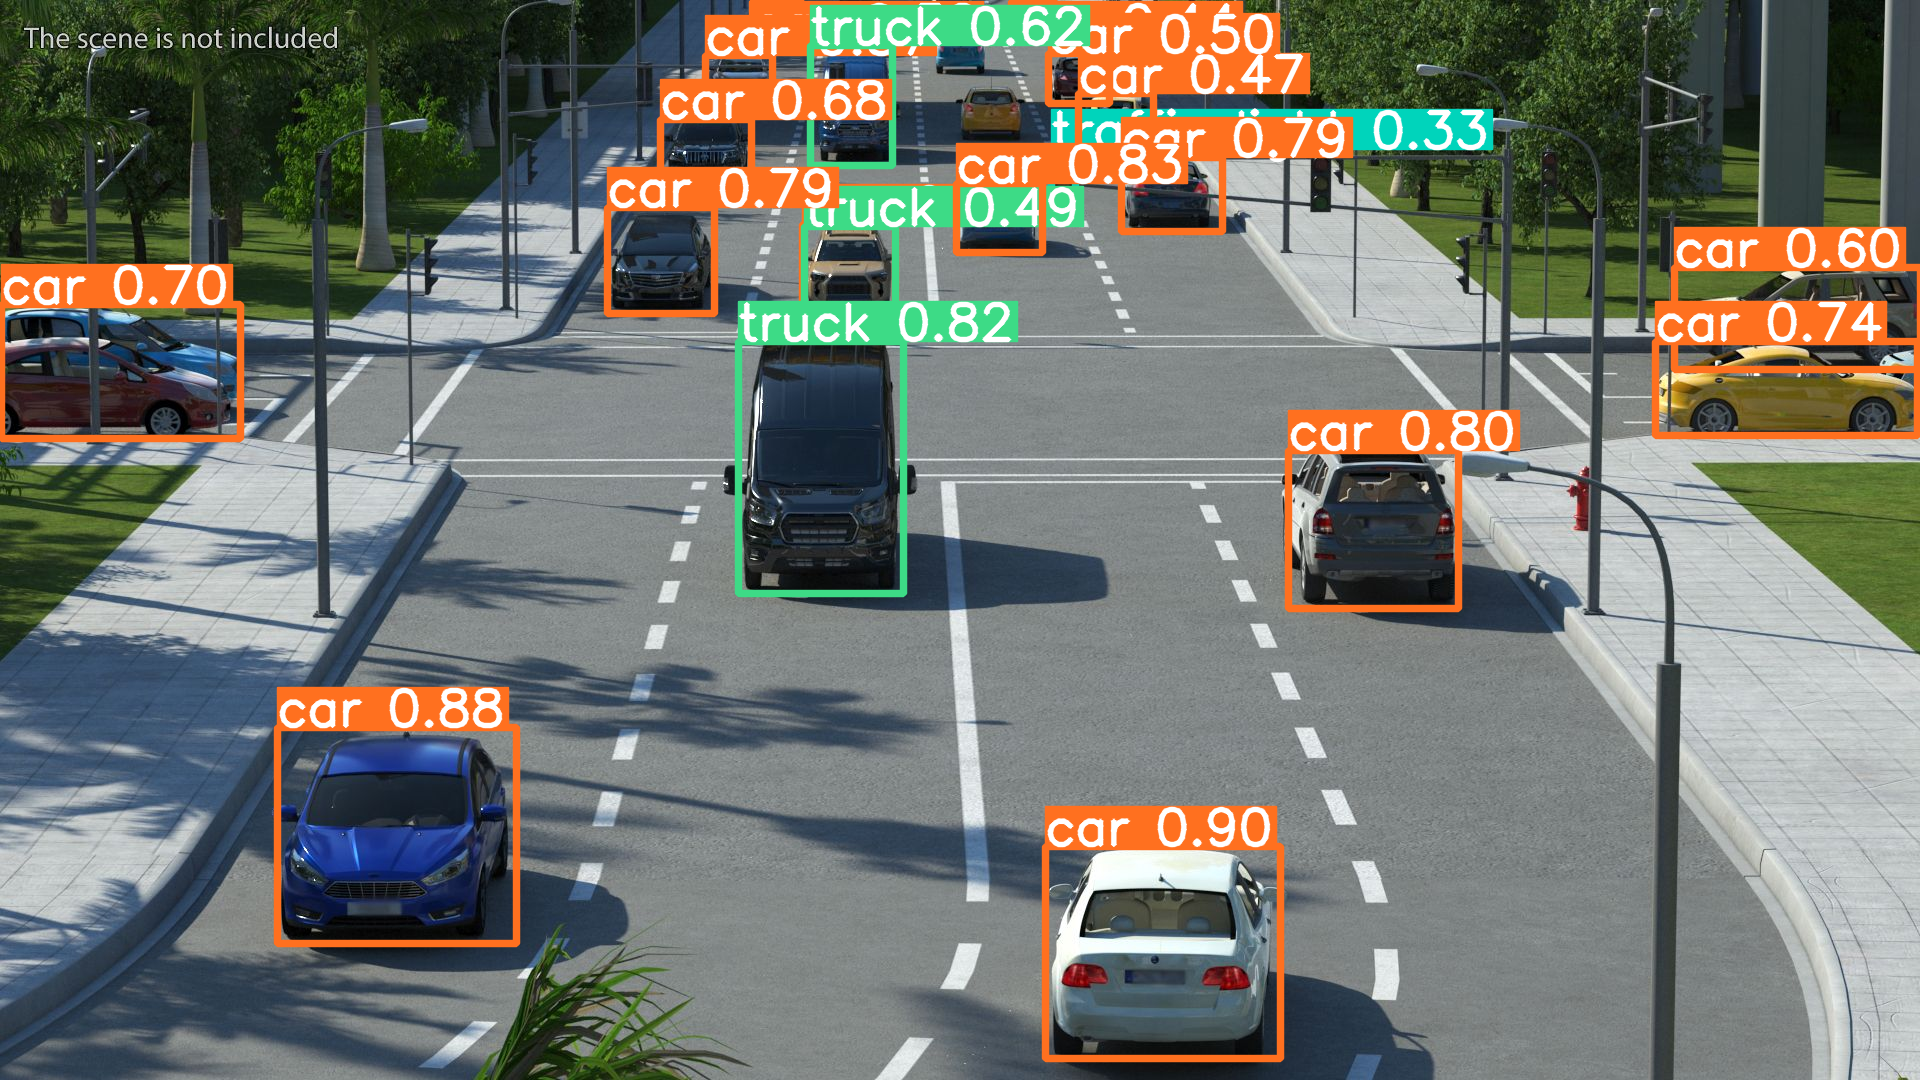

In [19]:
import torch
from PIL import Image
import numpy as np
import cv2

# Load the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

def detect_image(image_path):
    # Load image with OpenCV
    img = cv2.imread(image_path)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model(img)

    # Process results
    results.show()  # or results.save(), results.xyxy, etc.

detect_image('/content/image.jpg')

In [20]:
cap = cv2.VideoCapture(0)  # Use 0 for webcam

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        # Perform detection on each frame
        results = model(frame)

        # Convert results to numpy array and display
        cv2.imshow('YOLOv5 Detection', np.squeeze(results.render()))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


**Customize and Optimize**

Modify the code to suit your specific requirements, such as adjusting confidence thresholds or only detecting certain classes.
Optimize for your use case, considering factors like speed vs. accuracy trade-offs.

**Important Notes**


 Actual implementations can be more complex, especially for custom datasets or specific optimization requirements.
Always check the official documentation or GitHub repositories for the latest methods and best practices.
Ensure you have the appropriate hardware (like a good GPU) for efficient training and inference if dealing with large or numerous images.